# Project resolution of optical dataset onto microwave dataset

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import xarray
import rasterio
import gdal

%matplotlib inline

In [2]:
mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

In [3]:
opt_path_out = r"../Data/optical-rs/optical-cropped/"

In [4]:
dataset_mw = xarray.open_dataset(mw_path).rio.write_crs(
    "epsg:3413", inplace=True
)  # add EPSG
dataset_mw = dataset_mw.where(
    dataset_mw["time"] == np.datetime64("2019-06-08"), drop=True
)  # only use one day for now
data_mw = dataset_mw["melt"]
data_opt = xarray.open_dataarray(opt_path)

In [5]:
data_mw.rio.to_raster("data_mw.tif")
# data_omw_tif = xarray.open_dataarray("data_mw.tif")
# data_omw_tif

In [7]:
# put to propper folder

In [7]:
def print_raster(raster):
    print(
        f"shape: \n   Y: {raster.rio.shape[0]} \n   X: {raster.rio.shape[1]}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: \n   minx = {raster.rio.bounds()[0]} \n   miny = {raster.rio.bounds()[1]} \n   maxx = {raster.rio.bounds()[2]} \n   maxy = {raster.rio.bounds()[3]}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )


# print("Microwave TIF Raster:\n----------------")
# print_raster(data_omw_tif)
# print("Optical Raster:\n----------------")
# print_raster(data_opt)

## Test (Nina's?)

In [9]:
with rasterio.open("data_mw.tif") as src_mw:
    with rasterio.open(opt_path) as src_opt:
        opt_tif = src_opt.read(1)
        mw_tif = src_mw.read(1)
        upscaled_mw = np.zeros(opt_tif.shape)
        for row, col in np.argwhere(~np.isnan(mw_tif)):
            lon, lat = rasterio.transform.xy(
                src_mw.transform, row, col, offset="center"
            )
            row_temp, col_temp = rasterio.transform.rowcol(src_opt.transform, lon, lat)
            upscaled_mw[row_temp, col_temp] = 1

In [92]:
from rasterio.enums import Resampling

upscale_factor = 25
new_width = data_mw.rio.width * upscale_factor
new_height = data_mw.rio.height * upscale_factor

data_mw_upsampled = data_mw.rio.reproject(
    data_mw.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

del data_mw_upsampled.attrs["grid_mapping"]
data_mw_upsampled.rio.to_raster("data_mw_upsampled.tif")

c:\Users\ninaz\anaconda3\envs\my-env\lib\site-packages\rioxarray\raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [175]:
with rasterio.open("data_mw_upsampled.tif") as src_mw_upsampled:
    with rasterio.open("data_mw.tif") as src_mw:
        with rasterio.open(opt_path) as src_opt:
            upscaled_mw = np.zeros(src_mw_upsampled.shape)
            data_mw_full = xarray.open_dataset(mw_path).rio.write_crs(
                "epsg:3413", inplace=True
            )  # add EPSG
            for row, col in np.argwhere(~np.isnan(src_mw.read(1))):
                lon, lat = rasterio.transform.xy(
                    src_mw.transform, row, col, offset="center"
                )
                # bound= rasterio.transform.array_bounds(row, col,src_mw.transform)
                print(lon, lat)

                # row_new, col_new = rasterio.transform.rowcol(src_mw_upsampled.transform,lon,lat)
                # print(row, col, lon, lat)
            #    print(row, col, lon, lat)

-650000.0 -625000.0
-625000.0 -625000.0
-600000.0 -625000.0
-575000.0 -625000.0
-550000.0 -625000.0
-450000.0 -625000.0
-650000.0 -650000.0
-625000.0 -650000.0
-600000.0 -650000.0
-575000.0 -650000.0
-550000.0 -650000.0
-500000.0 -650000.0
-475000.0 -650000.0
-450000.0 -650000.0
-425000.0 -650000.0
-400000.0 -650000.0
-650000.0 -675000.0
-625000.0 -675000.0
-600000.0 -675000.0
-575000.0 -675000.0
-550000.0 -675000.0
-525000.0 -675000.0
-500000.0 -675000.0
-475000.0 -675000.0
-450000.0 -675000.0
-425000.0 -675000.0
-400000.0 -675000.0
-375000.0 -675000.0
-350000.0 -675000.0
-325000.0 -675000.0
125000.0 -675000.0
150000.0 -675000.0
175000.0 -675000.0
200000.0 -675000.0
-650000.0 -700000.0
-625000.0 -700000.0
-600000.0 -700000.0
-575000.0 -700000.0
-550000.0 -700000.0
-525000.0 -700000.0
-500000.0 -700000.0
-475000.0 -700000.0
-450000.0 -700000.0
-425000.0 -700000.0
-400000.0 -700000.0
-375000.0 -700000.0
-350000.0 -700000.0
-325000.0 -700000.0
75000.0 -700000.0
100000.0 -700000.0
125000.

In [ ]:
# VEDRANS CODE
"""
# manually upscale facebook data to same resolution
upscaled_fb = np.zeros(fb_resampled.shape)
for row, col in np.argwhere(fb > 0):
    # find lat long of the original point in the original raster
    lon, lat = rasterio.transform.xy(raster_trans,row,col,offset='center')
    # find the row col of the GPS point in the new reference system
    row, col = rasterio.transform.rowcol(resample_transform,lon,lat)
    # fill in the cell on the new raster
    #upscaled_fb[row,col] = 1
"""

## Manually change resolution

1. shift
2. crop
3. duplicate optical dataset/ resample.
4. get coordinates for each pixel from opt
5. get values for each coordinate from old 
6. update values in opt copy

In [9]:
data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
data_opt = xarray.open_dataarray(opt_path)

data_mw.rio.to_raster( 'data_mw_tif.tif')
data_omv_tif = xarray.open_dataarray('data_mw_tif.tif')

### 1. Shift

In [10]:
data_mw['x'] = [i+500 for i in data_mw['x']]
data_mw['y'] = [i-500 for i in data_mw['y']]

In [11]:
print('OPtical')
print_raster(data_opt)
print('MICROWAVE')
print_raster(data_mw)


OPtical
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413

MICROWAVE
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662000.0 
   miny = -3338000.0 
   maxx = 838000.0 
   maxy = -613000.0
sum: 358.0
CRS: EPSG:3413



### 2. Crop

In [12]:
cut_maxx= min(data_mw.rio.bounds()[2], data_opt.rio.bounds()[2])
cut_miny= max(data_mw.rio.bounds()[1], data_opt.rio.bounds()[1])
cut_minx= max(data_mw.rio.bounds()[0], data_opt.rio.bounds()[0])
cut_maxy= min(data_mw.rio.bounds()[3], data_opt.rio.bounds()[3])

In [13]:
# cut optical
overlap_window = (cut_minx,cut_maxy,cut_maxx,cut_miny)
gdal.Translate(opt_path_out + 'data_opt_cropped.tif', opt_path, projWin = overlap_window)



data_opt_cropped = xarray.open_dataarray(opt_path_out + 'data_opt_cropped.tif')
print_raster(data_opt_cropped)

shape: 
   Y: 2676 
   X: 1475
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3338000.0 
   maxx = 838000.0 
   maxy = -662000.0
sum: 324295.53125
CRS: EPSG:3413



### 3. Resample/ duplicacte optical dataset

### 4. get coord for each pixel in data_opt

In [ ]:
# add progress bar

In [ ]:
# 4. get coordinates for each pixel from optical
# 5. get values for each coordinate from old 
# 6. update values in opt copy

zeros = np.zeros(data_opt.shape[1:]) # (2, 2)) #

with rasterio.open('data_mw.tif') as src_mw:
    with rasterio.open(opt_path) as src_opt:
        trans_opt = src_opt.transform
        data_opt_meta = src_opt.meta
        print(data_opt_meta)
        for row in range(data_opt.shape[1]): # 2):#
            for col in range(data_opt.shape[2]): # 2):#
                # get coord from optical:
                lon, lat = rasterio.transform.xy(trans_opt,row,col,offset='center') # maybe use upscaled mw 
                # get value from mw dataset:
                val = list(src_mw.sample([(lon, lat)]))[0][0]
                # write values to matrix:
                zeros[row][col] = val
                #print(val)


In [ ]:
#maybe write just not 0 and not nan???

In [46]:
# 315 min
# save that matrix just in case
#np.isnan(np.min(zeros))
zeros[np.isnan(zeros)] = -1
np.savetxt('mw_val_matrix.csv', zeros, fmt="%d", delimiter=",")

In [52]:
zeros[zeros == -9999] = -1

In [57]:
zeros.min()

-1.0

In [47]:
# create copy of cropped opt data, update values with zeros matrix and write to mw folder
# nope
# write new file to folder containing new mw data in opt shape

In [65]:
# Write to TIFF
kwargs = data_opt_meta
kwargs.update(
    dtype=rasterio.float32,
    count=1#,    compress='lzw'
    ) # transform same???
    

In [66]:
with rasterio.open('out_new_band.tif', 'w', **kwargs) as dst:
    dst.write_band(1, zeros.astype(rasterio.float32))

In [46]:
data_mw_fine= xarray.open_dataarray('out_new_band.tif')

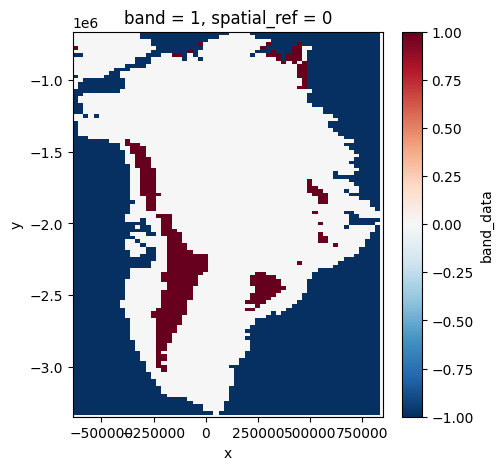

In [69]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
data_mw_fine.plot(ax=axes)
#data_opt.plot(ax=axes[1])
plt.draw()

In [ ]:
# for next iterations:

# copy this dataset, make all 0 and -1 - initialize matrix like this. update only values == 1

### 7. compare to sampled dataset

In [ ]:
# delete craeted shit?

In [ ]:
# 

## Reproject/ resample using rasterio

### Change resolution through rio.reproject_match

In [8]:
# look at nodata and min max before reprojecting
print('OPT')
with rasterio.open(opt_path) as src_opt:
        print(src_opt.meta)
        tt= src_opt.read()
        print(f'min:{tt.min()}')
        print(f'max:{tt.max()}')

OPT
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1487, 'height': 2687, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(1000.0, 0.0, -637000.0,
       0.0, -1000.0, -662000.0)}
min:-3.4028234663852886e+38
max:4.195837497711182


In [9]:
print('MW')
with rasterio.open('data_mw.tif') as src_mw:
        print(src_mw.meta)
        mw = src_mw.read()
        np.nan_to_num(mw, nan=-1, copy= False) # inplace
        # print(f'min:{mw.min()}')
        # print(f'max:{mw.max()}')
        kwargs1 = src_mw.meta.copy()

MW
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 60, 'height': 109, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(25000.0, 0.0, -662500.0,
       0.0, -25000.0, -612500.0)}


In [10]:
# overwrite mw with fixed band
with rasterio.open('data_mw.tif', 'w', **kwargs1) as dst:
    dst.write_band(1, mw[0])

# open data_mw.tif again?
data_mw_tif = xarray.open_dataarray("data_mw.tif")
# remove previous open if its unused

In [13]:
np.unique(data_mw_tif)

array([-1.,  0.,  1.], dtype=float32)

In [ ]:
# do thiiis before reprojecting???:

In [12]:
data_mw_tif['x'] = [i+500 for i in data_mw_tif['x']]
data_mw_tif['y'] = [i-500 for i in data_mw_tif['y']]
# maybe no need bc rio.reproject_match will reproject to match the resolution, projection, AND REGION of another raster.

In [14]:
print('before reprojection:')
print(np.unique(data_mw_tif, return_counts=True))


before reprojection:
(array([-1.,  0.,  1.], dtype=float32), array([2860, 3322,  358]))


##### Reprojection:

In [15]:
data_repr_mw = data_mw_tif.rio.reproject_match(data_opt) # raster to match in parenth - try make mw to opt resolution (but not scale so opt scale shouldn't impact?)
# before data_mw.rio....
#print("Reprojected Raster:\n-------------------")
#print_raster(data_repr_mw)

In [16]:
print('after reprojection:')
print(np.unique(data_repr_mw, return_counts=True))

# need to replace again???

after reprojection:
(array([-1.0000000e+00,  0.0000000e+00,  1.0000000e+00,  3.4028235e+38],
      dtype=float32), array([1666875, 2057725,  222500,   48469]))


In [44]:
#temp test put large/ nan to 2 and see if its just corners if yes - cut and done


#data_repr_mw[0][data_repr_mw[0] > 1] = 2
max_val = data_repr_mw.max()
#adata_repr_mw = np.where(data_repr_mw==max_val, 2, data_repr_mw) # bad bc turns to normal array
bdata_repr_mw = xarray.where(data_repr_mw!=max_val, data_repr_mw,  2)
#bdata_repr_mw = xarray.DataArray.where(data_repr_mw!=max_val, other = 2, drop = True)


In [35]:
type(bdata_repr_mw)

xarray.core.dataarray.DataArray

In [40]:
np.unique(bdata_repr_mw)

array([0., 1.])

In [20]:
a = np.random.randint(0, 5, size=(5, 4))
a

array([[4, 1, 1, 1],
       [0, 0, 1, 2],
       [1, 4, 3, 3],
       [0, 4, 3, 0],
       [1, 1, 4, 3]])

In [28]:
a = np.where(a==-101, 55, a)


In [29]:
a

array([[55,  1,  1,  1],
       [ 0,  0,  1,  2],
       [ 1, 55,  3,  3],
       [ 0, 55,  3,  0],
       [ 1,  1, 55,  3]])

In [ ]:
print("more info")

#print("before:\n----------------")
#print_raster(data_mw_tif)
print("after:\n----------------")
print_raster(data_repr_mw)
print("opt:\n----------------")
print_raster(data_opt)

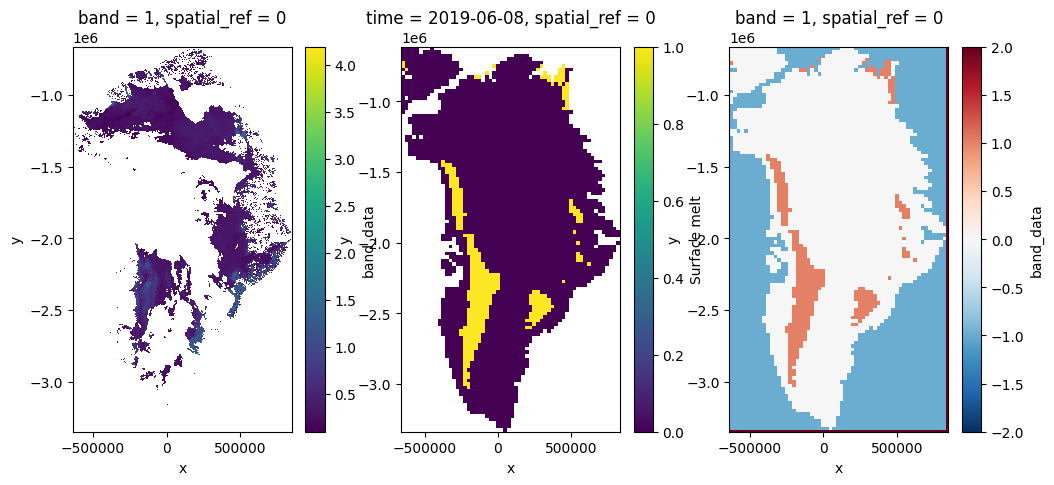

In [45]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))
data_opt.plot(ax=axes[0])
data_mw.plot(ax=axes[1])
bdata_repr_mw.plot(ax=axes[2])
plt.draw()
# need to fix scale and nans!!!

### Change resolution through transform - FAILED
code from here to be ignored for now

1. higher resolution optical

In [ ]:
# check current resolution
print_raster(data_opt) 

shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



In [ ]:
# rasterio's transform attribute https://rasterio.readthedocs.io/en/latest/quickstart.html

from rasterio.enums import Resampling

image = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"
upscale_factor = 2

with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

   
    # print('Shape before resample:', dataset.shape)
    # print('Shape after resample:', data.shape[1:])

    # scale image transform
    dst_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )B

    # print('Transform before resample:\n', dataset.transform, '\n')
    # print('Transform after resample:\n', dst_transform)

    ## Write outputs
    # set properties for output

    #rasterio.warp.reproject(    )

    dst_kwargs = dataset.meta.copy()
    dst_kwargs.update(
        {
            "transform": dst_transform,
            "width": data.shape[-1],
            "height": data.shape[-2],
            #"nodata": 0,  
        }
    )


Shape before resample: (2687, 1487)
Shape after resample: (5374, 2974)
Transform before resample:
 | 1000.00, 0.00,-637000.00|
| 0.00,-1000.00,-662000.00|
| 0.00, 0.00, 1.00| 

Transform after resample:
 | 500.00, 0.00,-637000.00|
| 0.00,-500.00,-662000.00|
| 0.00, 0.00, 1.00|


In [ ]:
with rasterio.open("temp-2019-06-08_grain_diameter.tif", "w", **dst_kwargs) as dst:
    # iterate through bands
    for i in range(data.shape[0]):
            dst.write(data[i].astype(rasterio.uint32), i+1)

In [ ]:
# open above rewritten array
data_opt_temp = xarray.open_dataarray("temp-2019-06-08_grain_diameter.tif")

In [ ]:
data_opt_temp[0]
# whyy these values and not nan same as before?

<xarray.DataArray 'band_data' (y: 5374, x: 2974)>
array([[2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       ...,
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -6.368e+05 -6.362e+05 ... 8.492e+05 8.498e+05
  * y            (y) float64 -6.622e+05 -6.628e+05 ... -3.348e+06 -3.349e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area

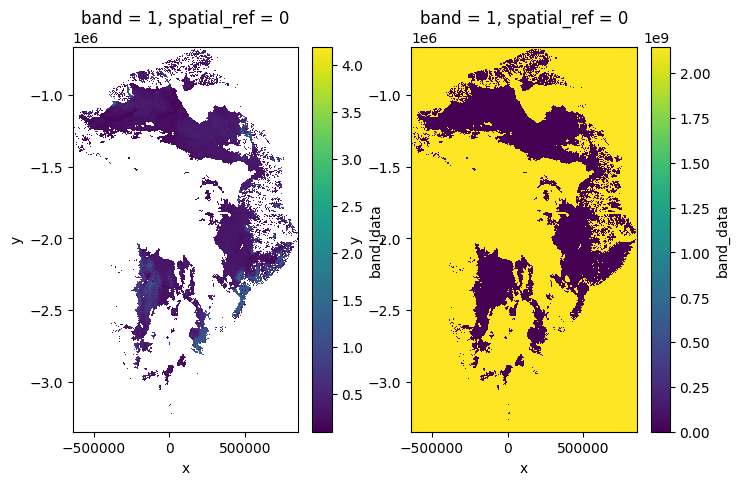

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_opt.plot(ax=axes[0])
data_opt_temp.plot(ax=axes[1])
plt.draw()

In [ ]:
# seems to have lost a lot of information

# figure out what went wrong:
# looks like inverted and lost gray gradient
# maybe rasterize intead of writing??

#### Inspect errors from above transformation:

In [ ]:
print('ORIG:')
print_raster(data_opt) 
print('NEW:')
print_raster(data_opt_temp) 

ORIG:
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413

NEW:
shape: 
   Y: 5374 
   X: 2974
resolution: (500.0, -500.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 2.6907128295849984e+16
CRS: EPSG:3413



In [ ]:
with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read()

In [ ]:
data1.shape # (1, 2687, 1487)
data.shape #(1, 5374, 2974)

(1, 2687, 1487)

In [ ]:
np.unique(data) # 2974

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.6269281e+00,  3.6706243e+00,  3.9512947e+00], dtype=float32)

In [ ]:
np.unique(data1) # size 1487

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

In [ ]:
band_id = 1  

raster = rasterio.open(opt_path) #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)


print(band_arr.shape)
np.unique(band_arr)

(2687, 1487)


array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

In [ ]:
band_id = 1  

raster = rasterio.open("temp-2019-06-08_grain_diameter.tif") #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)


print(band_arr.shape)
np.unique(band_arr)

(5374, 2974)


array([0.0000000e+00, 1.0000000e+00, 2.0000000e+00, 3.0000000e+00,
       2.1474836e+09], dtype=float32)

In [ ]:
# shape_ = 1487, 2687
# test_transform = rasterio.transform.from_bounds(*data_opt.rio.bounds(), *shape_) # west, south, east, north, width, height

## Jaccard similarity

https://python-bloggers.com/2021/12/jaccard-similarity-and-jaccard-distance-in-python/

In [ ]:
# now measure difference between reproject and manual

In [47]:
data_mw_fine.shape


(1, 109, 60)

In [48]:
bdata_repr_mw.shape

(1, 2687, 1487)

In [49]:
data_mw_fine_git= xarray.open_dataarray('out_new_band_git.tif')

In [51]:
data_mw_fine_git.shape

(1, 2687, 1487)

In [54]:
def jaccard_similarity(A, B):
    #Find intersection of two sets
    A = set(A)
    B = set(B)
    nominator = A.intersection(B)
    #Find union of two sets
    denominator = A.union(B)
    #Take the ratio of sizes
    similarity = len(nominator)/len(denominator)
    
    return similarity

In [55]:
jaccard_similarity(data_mw_fine_git, bdata_repr_mw)

TypeError: unhashable type: 'DataArray'

In [56]:
#myList = [[32, 12, 52, 63], [32, 64, 67, 52], [64,64,17,34], [17, 76, 98]]
my_set = set.union(*map(set,bdata_repr_mw))
print (my_set)
#set([32, 64, 34, 67, 76, 12, 98, 17, 52, 63])

TypeError: unhashable type: 'DataArray'

In [ ]:
def calculate_score_mask(y_true, y_pred):
    """
    Function calculate jaccard score for real vs mask

    :param y_true:
    :param y_pred:
    :return:
    """
    num_mask_channels = y_true.shape[0]

    result = np.ones(num_mask_channels)

    for mask_channel in range(num_mask_channels):
        intersection = np.dot(y_true[mask_channel, ...].flatten(), y_pred[mask_channel, ...].flatten())
        _sum = y_true[mask_channel, ...].sum() + y_pred[mask_channel, ...].sum()
        if _sum - intersection != 0:
            result[mask_channel] = intersection / (_sum - intersection)
    return np.mean(result)

In [ ]:
def calculate_polygon_match(image_id, num_mask_channels=10):
    """
    calculates jaccard index between before poly and after poly

    Ideally should be 1

    :param image_id:
    :param num_mask_channels:
    :return:
    """

    image = tiff.imread(os.path.join(data_path, 'three_band', image_id + '.tif'))

    width = image.shape[1]
    height = image.shape[2]

    mask_before = generate_mask(image_id, width, height, num_mask_channels=num_mask_channels)

    polygons = mask2polygons(mask_before, image_id)
    predicted_mask = polygons2mask(polygons, width, height, image_id)

    mask = generate_mask(image_id, width, height)

    return calculate_score_mask(mask, predicted_mask)

In [57]:
import difflib

In [60]:
s1=[1,8,3,9,4,9,3,8,1,2,3]
s2=[1,8,1,3,9,4,9,3,8,1,2,3]
sm=difflib.SequenceMatcher(None,s1,s2)
sm.ratio()

0.9565217391304348

In [61]:
set(bdata_repr_mw)

TypeError: unhashable type: 'DataArray'

In [65]:
for index, values in enumerate(bdata_repr_mw):
    print(index)
    print('---------------------------')
    print('values')
    print(values)
    print('---------------------------')
    for ii in values:
        print(ii)
        print('---------------------------')
        for jj in ii:
            print(jj)

SyntaxError: invalid syntax (1393063824.py, line 4)